In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

## 0-th example

### fit a model

In [3]:
train_X = torch.rand(10,2)
Y = 1 - torch.norm(train_X - 0.5, dim=-1, keepdim=True)
Y = Y + 0.1 * torch.rand_like(Y) # noise
train_Y = standardize(Y)

gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

### Construct an acquision function

In [4]:
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

### Optimize the acquision function

In [5]:
from botorch.optim import optimize_acqf
bounds = torch.stack([torch.zeros(2), torch.ones(2)])
candidate,acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate

tensor([[0.4492, 0.4662]])

# [Fitting models in BoTorch with a torch.optim.Optimizer](https://botorch.org/tutorials/fit_model_with_torch_optimizer)


BoTorch version of GPyTorch's [Simple GP Regression.](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html)

In [17]:
import matplotlib.pyplot as plt 
import math
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

$$ y = sin(2πx)+ϵ \\ 
error \quad ϵ∼N(0,0.04)$$

In [18]:
train_X = torch.linspace(0, 1, 15, dtype=dtype, device=device)

train_X = train_X.unsqueeze(1)

train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 *torch.randn_like(train_X)

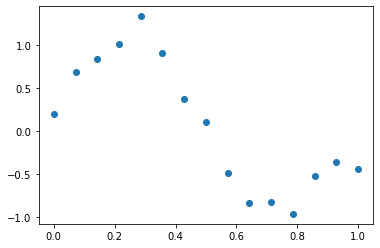

In [25]:
plt.scatter(train_X.cpu().detach().numpy(), train_Y.cpu().detach().numpy())
plt.show()

### Initialize the model
with SingleTaskGP (which adopts GaussianLikelihood)

### So, what is a MODEL composed of? 
See [Frazier 2018](https://arxiv.org/abs/1807.02811) for a breif explanation, or [Rasmussen and Williams 2006](http://www.gaussianprocess.org/gpml/chapters/) for a more comprehensive explanation.

<ins>This part needs a revision</ins>  
In short, a (GP) model constructs mean vector and covariance matrix of the prior data points. 
![Frazier18_eq3](Frazier_18_eq3.png)

where $\mu_0$ and $\Sigma_0$ are called *mean function* and *covariance function/kernel*. 
A common approach is that to decomposed the equation into system of linear equations by Cholesky decomposition (Algorithm 2.1 of RW06).  
Althought it is sometimes assumed that $\mu_0 = const.$, the kernel $\Sigma_0$ for measuring covariance is quite sophisticated. One popular choice, called Matern kerenl, is given as:
![Marten](GP_Marten_kernel.png)

and that's basically what GP model implementation such as scikit-optimize and GPytorch do.


*Extra trees*, *Random forest* are another possibilities for surrogate function [Surrogate model comparison](https://scikit-optimize.github.io/stable/auto_examples/strategy-comparison.html#sphx-glr-auto-examples-strategy-comparison-py)

< This section is taken from Botorch's [model description page](https://botorch.org/docs/models)>
 
### BoTorch Standard models
BoTorch does NOT assume Gaussian Process as models. However, all the pre-built standard models are GPs. Other types of models can be easily implemented and used as far as the implementation conforms to Bototch API. 

#### SingleTask GPs
In contrast to Single Task model, 
> Multi-Task Model makes use of a logical grouping of inputs/observations (as in the underlying process). For example, there could be multiple tasks where each task has a different fidelity.

1. SingleTaskGP: a single-task exact GP that infers a homoskedastic noise level (no noise observations).
2. FixedNoiseGP: a single-task exact GP that uses fixed observation noise levels (requires noise observations).
3. HeteroskedasticSingleTaskGP: a single-task exact GP that models heteroskedastic noise using an additional internal GP model (requires noise observations).

#### Model List of Single-Task GPs
1. ModelListGP: A multi-output model in which outcomes are modeled independently, given a list of any type of single-task GP. This model should be used when the same training data is not used for all outputs.

#### Multi-Task GPs
1. MultiTaskGP: a Hadamard multi-task, multi-output GP using an ICM kernel, inferring the noise level (does not require noise observations).
2. FixedNoiseMultiTaskGP: a Hadamard multi-task, multi-output GP using an ICM kernel, with fixed observation noise levels (requires noise observations).

In [3]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan

model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

In [13]:
print(model.train_inputs)
print(model.train_targets)

(tensor([[0.0000],
        [0.0714],
        [0.1429],
        [0.2143],
        [0.2857],
        [0.3571],
        [0.4286],
        [0.5000],
        [0.5714],
        [0.6429],
        [0.7143],
        [0.7857],
        [0.8571],
        [0.9286],
        [1.0000]], device='cuda:0'),)
tensor([-0.2118,  0.3412,  0.9194,  0.9378,  0.9158,  0.5417,  0.5972,  0.1728,
        -0.7004, -0.7287, -0.9989, -1.0510, -0.7704, -0.3525, -0.1702],
       device='cuda:0')


### Define marginal loglikelihood

Why do I need to define marginal likelihood in the first place? (Skopt tutorial never mentioned about marginal likelihood...?)

Estimating the underlying mean and the underlying covariance of prior data points involves choosing the right *mean function* $\mu_0$ and *covariance kernel* $\Sigma_0$ that are specified by a set of hyperparameters $\eta$.  
**First**, Most straighforward approach would be to find the *maximum likelihood estimate*(MLE) of

$$\hat{\eta} = argmax P(f(x_{1:n}) \vert \eta)$$  

**Second**, assuming that each hyperparater is drawn from a prior distribution can add a better controlled result, where now the goal is to find the *maximum a posteriori* (MAP) estimate 

$$\hat{\eta} = argmax P(\eta \vert f(x_{1:n})) = argmax P(f(x_{1:n} \vert \eta))P(\eta)$$

**Lastly**, the MAP approach can be further generalized as a *fully Bayesian* approach, where we marginalize f(x) over all possible hyperparmeters. 
$$P(f(x) = y \vert f(x_{1:n})) = \int{P(f(x) = y \vert f(x_{1:n}), \eta) P(\eta \vert f(x_{1:n}))d\eta}$$
, which can be approximated by MCMC sampling.

These three models correspond to GPytorch's `models.ExactGP`, `models.ApproximateGP`, and `models.deep_gps.DeepGp`, respectively.

In [4]:
from gpytorch.mlls import ExactMarginalLogLikelihood

What does it mean to define marginal loglikelihood?  
`ExactMarginalLogLikelihood` seems very conveniet. But on what constraint it can calculate marginal likelihood?

Document says:
> The exact marginal log likelihood (MLL) for an exact Gaussian process with a Gaussian likelihood. This module will **not work with anything other** than a GaussianLikelihood and a ExactGP. It also cannot be used in conjunction with stochastic optimization.

Then, what to do with the *Other* models? shoul I provide the marginal likelihood or is there an approximate / more computationally intese alternate to `ExactMarginalLogLikelihood`?

Yes there are. 
`gpytorch.mlls` has a few more options: 
- VariationalELBO 
- PredictiveLogLikelihood
- GammaRobustVariationalELBO
- DeepApproximateMLL


In [5]:
model.likelihood

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): GammaPrior()
    (raw_noise_constraint): GreaterThan(1.000E-05)
  )
)

Since I haven't explictely specified a likelihood for my model, GaussianLikelihood must be the default for `SingleTaskGP`.  

#### Is it the only possiblity or just the default choice?
As the document says,
> Since we’re using exact inference, the likelihood **must be Gaussian**.


In [6]:
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified **dtype and device**
mll = mll.to(train_X)

### kernel optimizer

Use SGD to optimize kernel hyperparameter

In [10]:
from torch.optim import SGD

optimizer = SGD([{'params':model.parameters()}], lr=0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [33]:
NUM_EPOCHS = 150

model.train() # set to train mode

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    print(train_x.shape())
    output = model(train_X)
    
    loss = -mll(output, model.train_targets)
    # backpropagation: calculate gradient
    loss.backward()
    
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"noise: {model.likelihood.noise.item():>4.3f}" 
        )
    # update parameters
    optimizer.step()

NameError: name 'train_x' is not defined

In [23]:
model.eval();

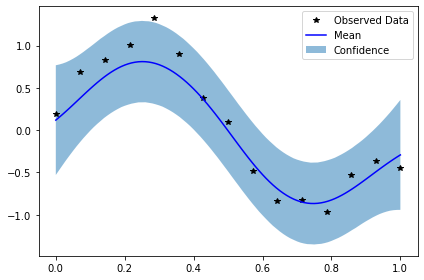

In [24]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()